# Assignment 4 : Reinforcement Learning 

### Himanshu Dhawale (801084142)

# I. Overview

Objective of this assignment is to implement Reinforcement learning algorithms Blackjack game. It is to understand Blackjack environment and train RL agent using SARSA or Q learning. In this assignment: 

1) Model for the problem was selected. 

2) Experimented the selected model with various parameters (γ, α, and ϵ).

3) Described the choice of selected parameters. 

4) Parameters that gave optimal results are selected and used for final training. 

5) Results for the outputs are visualized and outputs are explained. 


In [6]:
import collections
from IPython.display import clear_output
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict

from tqdm import tqdm

import gym
from gym import spaces
from gym.utils import seeding
%matplotlib inline

# II. Problems 
 
# Blackjack
 <img src="https://upload.wikimedia.org/wikipedia/commons/a/a2/Blackjack_game_1.JPG" width=800 />
 
 
 <b> Game Introduction and Rules: </b> Blackjack is a card game where the goal is to obtain cards that sum to as
 near as possible to 21 without going over.  They're playing against a fixed
 dealer.
 
 Face cards (Jack, Queen, King) have point value 10.
 Aces can either count as 11 or 1, and it's called 'usable' at 11.
 This game is placed with an infinite deck (or with replacement).
 
 The game starts with each player getting two face up cards and dealer
 having one face up and face down card and the player needs to bet an 
 amount of money within range of 1 to max bet (10). 
 Note: Face up means that you will know what the card is.
 
 The player can request additional cards (hit=1) until they decide to stop
 (stick=0) or exceed 21 (bust).
 
 After the player sticks, the dealer reveals their facedown card, and draws
 until their sum is 17 or greater (fixed policy).  If the dealer goes bust the player wins.
 You won't see the dealer's facedown card, just you will know if you have or lost
 and you will get appropriate reward of +1 if you win, -1 if you loose or 0 if the match
 is drawn.
 (It is freedom of choice for you to change the reward function. If you want to change, you should explain the reason of the change.)
 
 If the player wins, the amount he has bet will be doubled and given back. 
 If the player and dealer have the same sum, then its a draw and the player will get
 back the money he has bet. 
 If the player loses then, the money he bet will be lost. 
 If neither player nor dealer busts, the outcome (win, lose, draw) is
 decided by whose sum is closer to 21. You are free to change the reward function to make it 
 learn more efficiently. (i.e.,  the amount of money the user is winning after each round). 
 
 Regardless of the number of players on the table, each player will be just playing against the 
 dealer independently of the other players.

# Player class definition

Player class defines an object for each BlackJack player with a given unique name. It has three attributes, the player's name, current cards in hand, and total balance left to play games. get_info() is getter method that prints out all three attributes.

In [7]:
class Player():
    """
        
        Player class to create a player object.
        eg: player = Player("player1", start_balance = 10)
        Above declaration will be for your agent.
        All the player names should be unique or else you will get error.
        
    """
    def __init__(self, player_name, start_balance = 10):
        self.player_name = player_name
        self.card = []
        self.starter_balance = start_balance
        self.total_balance = start_balance

    def recharge_account(self):
        self.total_balance = self.starter_balance
        
    def get_info(self):
        print("Player name: {}".format(self.player_name))
        print("Player card: {}".format(self.card))
        print("Player total_balance: {}".format(self.total_balance)) 

### Following functions are utilities and definition of card deck to play games and to check the game status.

In [8]:
# 1 = Ace, 2-10 = Number cards, Jack/Queen/King = 10
deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]

def cmp(a, b):
    return float(a > b) - float(a < b)

def draw_card(np_random):
    return int(np_random.choice(deck))

def draw_hand(np_random):
    return [draw_card(np_random), draw_card(np_random)]


def usable_ace(hand):  # Does this hand have a usable ace?
    return 1 in hand and sum(hand) + 10 <= 21


def sum_hand(hand):  # Return current hand total
    if usable_ace(hand):
        return sum(hand) + 10
    return sum(hand)


def is_bust(hand):  # Is this hand a bust?
    return sum_hand(hand) > 21


def score(hand):  # What is the score of this hand (0 if bust)
    return 0 if is_bust(hand) else sum_hand(hand)


def is_natural(hand):  # Is this hand a natural blackjack?
    return sorted(hand) == [1, 10]

# Blackjack Environment

In [9]:
class BlackjackEnv(gym.Env):
    """
    Simple blackjack environment
    
    Blackjack is a card game where the goal is to obtain cards that sum to as
    near as possible to 21 without going over.  They're playing against a fixed
    dealer.
    Face cards (Jack, Queen, King) have point value 10.
    Aces can either count as 11 or 1, and it's called 'usable' at 11.
    This game is placed with an infinite deck (or with replacement).
    The game starts with each (player and dealer) having one face up and one
    face down card.
    The player can request additional cards (hit=1) until they decide to stop
    (stick=0) or exceed 21 (bust).
    After the player sticks, the dealer reveals their facedown card, and draws
    until their sum is 17 or greater.  If the dealer goes bust the player wins.
    If neither player nor dealer busts, the outcome (win, lose, draw) is
    decided by whose sum is closer to 21.  The reward for winning is +1,
    drawing is 0, and losing is -1.
    The observation is: the players current sum, players current card, players balance left, 
    the dealer's one showing card (1-10 where 1 is ace),
    and whether or not the player holds a usable ace (0 or 1).
    
    Parameters
    ==========
    natural      boolean
                 option for 50% more reward on natural blackjack 
    
    """
    
    def __init__(self, natural=False):
        self.action_space = spaces.Discrete(2)
        self.observation_space = spaces.Tuple((
            spaces.Discrete(32),
            spaces.Discrete(11),
            spaces.Discrete(2)))
        self.seed()
        self.total_players = 1
        self.players = {}
        self.natural = natural
        self.dealer = []
        self.round_bet_info = {}
        self.max_bet_cap = 10

    def add_player(self, player_class):
        if player_class not in self.players and len(self.players) < self.total_players:
            self.players[player_class.player_name] = player_class
        else:
            raise Exception("Maximum number of player allowed: {}. You can increase the player count while initializing the environment".format(len(self.players)))

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, player_name, action):
        assert self.action_space.contains(action)
        if action:  # hit: add a card to players hand and return
            self.players[player_name].card.append(draw_card(self.np_random))
            if is_bust(self.players[player_name].card):
                done = True
                reward = -1
            else:
                done = False
                reward = 0
        else:  # stick: play out the dealers hand, and score
            done = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(draw_card(self.np_random))
            reward = cmp(score(self.players[player_name].card), score(self.dealer))
            
            if self.natural and is_natural(self.players[player_name].card) and reward == 1:
                reward = 1.5
        if done:
            self.settle_balance(int(reward), player_name)
        return {'state':self._get_obs(player_name), 'reward': reward, 'is_round_done': done}

    def _get_obs(self, player_name):
        return {'player_info':self.get_player_obs(player_name), 
                'dealer_info': self.dealer[0]}

    def get_player_obs(self, player_name):
        return {'player_sum_card':sum_hand(self.players[player_name].card), 
                'player_card':self.players[player_name].card, 
                'player_total_balance':self.players[player_name].total_balance, 
                'usable_ace' : usable_ace(self.players[player_name].card)}
    
    def get_valid_bet_amount(self, player_name):
        print("player name: {} money left: {}".format(player_name, self.players[player_name].total_balance))
        if self.players[player_name].total_balance < 1:
            return {'is_round_done': True, 'valid_bet_amount': -1}
        max_bet_upper_limit = self.players[player_name].total_balance
        if self.players[player_name].total_balance >= self.max_bet_cap:
            max_bet_upper_limit = self.max_bet_cap            
        return {'is_round_done': False, 'valid_bet_amount': list(range(1, max_bet_upper_limit+1))}
            
    def init_round(self, player_name):         
        self.dealer = draw_hand(self.np_random)
        self.players[player_name].card = draw_hand(self.np_random)
        return {'state': self._get_obs(player_name)}        

    def bet_money(self, player_name, bet_amount):
        self.players[player_name].total_balance -= bet_amount
        self.round_bet_info[player_name] = bet_amount
            
    def settle_balance(self, is_winner, player_name):
        if is_winner == 1:
            print("player winner")
            self.players[player_name].total_balance += (2 * self.round_bet_info[player_name])
        elif is_winner == 0:
            print("Draw match")
            self.players[player_name].total_balance += self.round_bet_info[player_name]
        else:
            popop=1
            print("player loser, wont get back the money, try next round")
    
    def reset(self, natural=False):
        for player_name, player_class in self.players.items():
            player_class.recharge_account()
        self.natural = natural
        self.dealer = []
        self.round_bet_info = {}
        

## Explanation of code 

The Blackjack game environment is defined as follows. Inheriting, OpenAI.Gym.Env, it overrides the interfances to enable the interfaction with the same interfaces with other OpenAI Gym environments.

These are important member functions:

add_player: You can add your player object with some initial amount of money

step: you need to send the action using this function, actions are hit(1) or stand(0)

 returns {'state': player info and dealer info (_get_obs), 
          'reward': real-valued reward, 
          'is_round_done': True/Fasle}
_get_obs: returns the state of the env or required information you can use to build your agent.
      eg: {'player_info':{'player_sum_card': sum of cards, 
                          'player_card': list of cards, 
                          'player_total_balance': real-valued number, 
                          'usable_ace' : True/False}, 
          'dealer_info': dealer's first card}
init_round: will start a new round in the same game.

 returns {'state': player info and dealer info (_get_obs)}
reset: will reset the whole game and you will being again with the initial balance you had started the player object.

 returns nothing, will just reset the entire game.
bet_money: you can bet the amount using this method, takes in the money between (1, max_bet_cap). max_bet_cap is 10.

 returns nothing.

# Example run with random players

In [10]:
env = BlackjackEnv()
player1 = Player('player1')
env.add_player(player1)
#Number of games
number_of_games = 10

#Number of rounds
number_of_rounds = 20

for _game in range(number_of_games):

    env.reset()
    print("-"* 50)
    print("Game Number: {}".format(_game + 1))
    print("-"* 50)
    for _round in range(number_of_rounds): 
        print("%"* 50)
        print("Game Number: {} Round Number: {}".format(_game+1, _round+1))
        print("%"* 50)
        
        #Check if you have enough money left in the account to bet, if not break and start a new game
        valid_bet_flag = env.get_valid_bet_amount(player1.player_name)
        if valid_bet_flag['is_round_done']:
            print("You are out of money ! Will go to next game !!")
            break
        bet_amount = valid_bet_flag['valid_bet_amount']
        
        #Get the observations i.e state and use it to decide how much you want to bet
        round_obs = env.init_round(player1.player_name)
        print("Initial state: {}".format(round_obs))  
        
        # If you have just $1 left in the bank, you have no choice but to bet that amount 
        # and hopefully leave it to the fate for your agent to win and continue playing or just
        # start a new game
        if len(bet_amount) == 1 and bet_amount[0] == 1:
            print("You can only bet 1. So betting only 1.")
            random_bet = 1
        else:
            random_bet = np.random.choice(bet_amount)
        print("Random Init Bet: {}".format(random_bet))
        env.bet_money(player1.player_name, random_bet)
          
        
        # Look at the state and take actions, here the actions are selected randomly
        # you can use the agent to select the action
        random_action = np.random.randint(0, 2)
        print("Action taken: {}".format(random_action))

        #Use the selected action to actually take the action in env by calling step
        round_obs = env.step(player1.player_name, random_action)
        print("State after 1st action: {}".format(round_obs))

        #Check if the game is not over, if your action is stand then the game is over, else
        #the game continues in this loop until your action is stand
        while not round_obs['is_round_done']:
            #Select an random action and take the action
            random_action = np.random.randint(0, 2)
            print("Action taken: {}".format(random_action))
            round_obs = env.step(player1.player_name, random_action)
            print("State after nth action: {}".format(round_obs))

        #Round over, but the game will continue untill you have exhausted your initial money 
        print("Balance Left: {}".format(round_obs['state']['player_info']['player_total_balance']))
        print("Round over")
        print("-%-"*30)
        if (_round + 1) == (number_of_rounds):
            print("Max number of rounds played. If you see the message, you are the winner.")

# III. Methods

- Decide your TD learning approach: SARSA or Q-learning? 
- Describe your approach and the reason why you select it.
- Finish epsilon_greedy function and other TODOs. Explain it.
- Explain your codes.

## SARSA and Q-Learning

Both SARSA and Q-learning are Temporal Difference learning approaches. The difference between these approches lies in updating the Q table. 

In SARSA we update the Q with assumption that we follow a certain behavior policy. Thus, we call this as on-policy control, or SARSA.
$$
    Q(s_t, a_t) \leftarrow Q(s_t, a_t) + \alpha ( R_{t+1} + \gamma Q(s_{t+1}, a_{t+1}) - Q(s_t, a_t)) 
$$

In Q-learning without making assumption of behavior policy, we can explore other possible policies to update the Q. We call this as off-policy control, or Q-learning.
$$
    Q(s_t, a_t) \leftarrow Q(s_t, a_t) + \alpha ( R_{t+1} + \gamma \max_a Q(s_{t+1}, a) - Q(s_t, a_t)) 
$$

If we observe above two formulas used for updating the Q table we can see that in SARSA it is using the actual action that corresponds to s(t+1) to update action at s(t) where as in Q learning it using maximum reward action value at s(t+1) to update action at s(t).

The major difference is that Q-learning uses the action with maximum reward to update the action value. In SARSA, we use an action that is taken in previous state.

## TD learning approach: SARSA or Q-learning

For this problem I choose Q learning approach over SARSA because I donot care agents performance during the process of learning. I want the agent to explore all the possible policies and learn optimal greedy policy. I want agent to explore and learn the optimal policy of reaching the goal in minimum number of steps. Same in the case of Blackjack game I want agent to learn by exploring and also in case of Blackjack there can never be bad action until unless we explore it.
SARSA will approach convergence allowing for possible penalities from exploratory moves, while Q learning ignores them. SARSA is very conservative and if there is any large negative closer to optimal path it tends to avoid it where as Q learning tend to trigger that large negative reward in the name of exploration.

I want my agents to learn optimal policies directly as there is no risk or damage occured to agents or environment performing actions while exploring.



## Function approximator



Since I have used Q learning the function approximator used is this: <br>
π(s)=argmaxQ∗(s,a)

To use Q-values with function approximation, we need to find features that are functions of states and actions. In function approximation agent will choose maximum of state, action pair from our look up table.

I have used look up table (Q table) to determine the approximate value. 

In [11]:
class GamblerAgent:
    
    def __init__(self):
        self.env = env
        #player sum, dsum all, action=bet high or low
        self.Q1 = np.random.rand(32,11,2)
    
    def greedy(self,s,env):
        actions = [0,1]
        c=True
        a=self.Q1[s[0]][s[1]]
        #print("Available actions: ", actions)
        while c:
            if np.argmax(a) in actions:
                action= np.argmax(a)
                c=False
                
            else:
                a=np.delete(a,np.argmax(a))
                c=True
        
        print("selected action",action)
        return action  # greedy action selection
        
        
        
    def epsilon_greed(self,epsilon,s,env):
        
        if np.random.rand() < epsilon:
            actions = [0,1]
            return random.choice(actions)
        
        else:
            return self.greedy(s,env)
        
 

In [12]:
gambAgent=GamblerAgent()

# Gambler Agent
This agent has init constructor which fills random value for Q1 table. 

It has greedy method similar to Blackjack agent.

It has epsilon method similar to Blackjack agent.

In this the agent has two actions bet as high or bet as low.

The agent has two states player sum and dealer faceup card. 

We map this state and action values on Q1 table in this agent. 

This agent looks for the state and action previously explored during testing and chooses greedy action if it has earned good reward for that particular action.

I'm changing reward and punishing with the bet_amount the gambler agent used to bet. 

I'm also giving reward to gambler agent which depends on the bet_amount and blackjack occured or not. 

I'll modify more for the tournament and improve the minimum number of rounds. 

My average number of rounds is around 43 and minimum is 18. 


# RLAgent for Blackjack

In [13]:
import random
class RLAgent: 
    """
        Reinforcement Learning Agent Model for training/testing
        with Tabular function approximation
        
    """
    def __init__(self):
        self.env = env
        #self.size = env.get_size()
        #self.n_a = len(env.get_actions())
        # self.Q table including the surrounding border
        #self.Q = np.zeros((self.size[0], self.size[1], self.size[2], self.n_a))
        self.Q = np.random.rand(32,11,2,2)

        
    
    def greedy(self, Q, s,env):
        actions = [0,1]
        c=True
        a=Q[s[0]][s[1]][s[2]]
        #print("Available actions: ", actions)
        while c:
            if np.argmax(a) in actions:
                action= np.argmax(a)
                c=False
                
            else:
                a=np.delete(a,np.argmax(a))
                c=True
        
        print("selected action",action)
        return action  # greedy action selection
        
        
        
    def epsilon_greed(self, epsilon, s,env):
        
        if np.random.rand() < epsilon:
            actions = [0,1]
            return random.choice(actions)
        
        else:
            return self.greedy(self.Q,s,env)


        
    def train(self, **params):
        self.pp=BlackjackEnv()
        gamma = params.pop('gamma')
        alpha = params.pop('alpha')
        self.epsilon= params.pop('epsilon')
        maxiter= params.pop('maxiter') 
        maxstep= params.pop('maxstep',1000)
        i=1

        # online train
        # rewards and step trace
        rtrace = []
        steps = []
        self.actions=[]

        player=Player("Bot", start_balance = 10)
        self.pp.add_player(player)


        for i in range(maxiter):
            win=0
            loss=0
            rewards=[]        
            self.pp.reset()
            #self.pp.init_round()

            self.pp.init_round(player.player_name)
            #print("-"*100,i)
            
            for j in range(50):
                #r=0
                #clear_output()
                self.pp.init_round(player.player_name)
                current_balance=self.pp.get_player_obs(player.player_name)['player_total_balance']
                p_cardsum=self.pp.get_player_obs(player.player_name)['player_sum_card']
                d_cardsum=self.pp._get_obs(player.player_name)['dealer_info']
                eleven_ace=self.pp.get_player_obs(player.player_name)['usable_ace']
                #Check if you have enough money left in the account to bet, if not break and start a new game
                valid_bet_flag = self.pp.get_valid_bet_amount(player.player_name)
                if valid_bet_flag['is_round_done']:
                    print("You are out of money ! Will go to next game !!")
                    break
                bet_amount = valid_bet_flag['valid_bet_amount']
                if len(bet_amount) == 1 and bet_amount[0] == 1:
                    print("You can only bet 1. So betting only 1.")
                    random_bet = 1
     
                else:
                    #random_bet = np.random.choice(bet_amount)
                    ss=np.array([int(p_cardsum),int(d_cardsum)])
                    omg=gambAgent.epsilon_greed(self.epsilon,ss,self.pp)
                    if omg==0:
                        random_bet=np.random.randint(1,len(bet_amount))
                    else:
                        random_bet=1
              
                print("Random Init Bet: {}".format(random_bet))
                self.pp.bet_money(player.player_name, random_bet)
               

                s=np.array([int(p_cardsum),int(d_cardsum),int(eleven_ace)])
                a = self.epsilon_greed(self.epsilon, s,self.pp)
                #first
                result = self.pp.step("Bot", a)
                game_check=result['is_round_done']
                
                
                if(result['is_round_done']):
                    current_balance=self.pp.get_player_obs(player.player_name)['player_total_balance']
                    #balance=current_balance-bet_amount
                    p_cardsum=self.pp.get_player_obs(player.player_name)['player_sum_card']
                    d_cardsum=self.pp._get_obs(player.player_name)['dealer_info']
                    eleven_ace=self.pp.get_player_obs(player.player_name)['usable_ace']
                    s1=np.array([int(p_cardsum),int(d_cardsum),int(eleven_ace)])
                    #a1 = self.epsilon_greed(self.epsilon, s1,self.pp)
                    r = int(result['reward'])
                    r=r*random_bet
                    rewards.append(r)
                    self.Q[s[0]][s[1]][s[2]][a] = self.Q[s[0]][s[1]][s[2]][a] + alpha*(r+(gamma*max(self.Q[s1[0]][s1[1]][s1[2]]))-self.Q[s[0]][s[1]][s[2]][a])

                    gambAgent.Q1[s[0]][s[1]][omg] = gambAgent.Q1[s[0]][s[1]][omg] + alpha*(r+(gamma*max(gambAgent.Q1[s1[0]][s1[1]]))-gambAgent.Q1[s[0]][s[1]][omg])
                    continue
                    
                    

              
                while not result['is_round_done']:
                    current_balance=self.pp.get_player_obs(player.player_name)['player_total_balance']
                    #balance=current_balance-bet_amount
                    p_cardsum=self.pp.get_player_obs(player.player_name)['player_sum_card']
                    d_cardsum=self.pp._get_obs(player.player_name)['dealer_info']
                    eleven_ace=self.pp.get_player_obs(player.player_name)['usable_ace']
                    s=np.array([int(p_cardsum),int(d_cardsum),int(eleven_ace)])
                    a = self.epsilon_greed(self.epsilon, s,self.pp)
                    #Third
                    result = self.pp.step("Bot",a)
                    game_check=result['is_round_done']
                    r = int(result['reward'])
                    r=r*random_bet

                    p_cardsum=self.pp.get_player_obs(player.player_name)['player_sum_card']
                    d_cardsum=self.pp._get_obs(player.player_name)['dealer_info']
                    eleven_ace=self.pp.get_player_obs(player.player_name)['usable_ace']
                    s1=np.array([int(p_cardsum),int(d_cardsum),int(eleven_ace)])
                    a1 = self.epsilon_greed(self.epsilon, s1,self.pp)

                rewards.append(r)
                #Fourth
                self.Q[s[0]][s[1]][s[2]][a] = self.Q[s[0]][s[1]][s[2]][a] + alpha*(r+(gamma*max(self.Q[s1[0]][s1[1]][s1[2]]))-self.Q[s[0]][s[1]][s[2]][a])
                gambAgent.Q1[s[0]][s[1]][omg] = gambAgent.Q1[s[0]][s[1]][omg] + alpha*(r+(gamma*max(gambAgent.Q1[s1[0]][s1[1]]))-gambAgent.Q1[s[0]][s[1]][omg])

            rtrace.append(np.sum(rewards))
        return rtrace,self.Q # last trace of trajectory
    
    
    
    
    def test(self):
        self.pt=BlackjackEnv()
        win=0
        loss=0
        #maxstep=1000
        player_test=Player("Bot", start_balance = 10)
        self.pt.add_player(player_test)
        
        for i in range(3):
            #self.pt=env.init()
            self.pt.reset()
            

       
            #print("-"*100,i)
            
            for j in range(50):
                print("*"*20)
                print("Round is: ", j)
                self.pt.init_round(player_test.player_name)
                current_balance=self.pt.get_player_obs(player_test.player_name)['player_total_balance']
                p_cardsum=self.pt.get_player_obs(player_test.player_name)['player_sum_card']
                d_cardsum=self.pt._get_obs(player_test.player_name)['dealer_info']
                eleven_ace=self.pt.get_player_obs(player_test.player_name)['usable_ace']
                #Check if you have enough money left in the account to bet, if not break and start a new game
                valid_bet_flag = self.pt.get_valid_bet_amount(player_test.player_name)
                ss=np.array([int(p_cardsum),int(d_cardsum)])
                if valid_bet_flag['is_round_done']:
                    print("You are out of money ! Will go to next game !!")
                    break
                bet_amount = valid_bet_flag['valid_bet_amount']
                if len(bet_amount) == 1 and bet_amount[0] == 1:
                    print("You can only bet 1. So betting only 1.")
                    random_bet = 1
                    
                  
                else:
                    #random_bet = np.random.choice(bet_amount)
                    #random_bet = np.random.randint(1,2)
                    #random_bet = np.random.choice(bet_amount)
                    ss=np.array([int(p_cardsum),int(d_cardsum)])
                    omg=gambAgent.greedy(ss,self.pp)
                    if omg==0 and len(bet_amount)>=7:
                        random_bet=3
                    else:
                        random_bet=1
              

                print("Random Init Bet: {}".format(random_bet))
                self.pt.bet_money(player_test.player_name, random_bet)
                
              
                s=np.array([int(p_cardsum),int(d_cardsum),int(eleven_ace)])
                a = self.greedy(self.Q, s,self.pt)
                ##First
                result = self.pt.step("Bot", a)
                game_check=result['is_round_done']
                self.actions.append(a)
                r = result['reward']
                if (r>0):
                    win=win+1
                elif (r<0):
                    loss=loss+1
                    
                while not result['is_round_done']:
                    current_balnce=self.pt.get_player_obs(player_test.player_name)['player_total_balance']
                    #balance=current_balance-bet_amount
                    p_cardsum=self.pt.get_player_obs(player_test.player_name)['player_sum_card']
                    d_cardsum=self.pt._get_obs(player_test.player_name)['dealer_info']
                    eleven_ace=self.pt.get_player_obs(player_test.player_name)['usable_ace']
                    s=np.array([int(p_cardsum),int(d_cardsum),int(eleven_ace)])
                    a = self.greedy(self.Q, s,self.pt)
                    ##second
                    result = self.pt.step("Bot",a)
                    r = int(result['reward'])
                    if (r>0):
                        win=win+1
                    elif (r<0):
                        loss=loss+1
                print("Final Result: {}".format(result))
                print("**********")
        
        return win,loss,j
    
                
       
   

## Explanation of code

#### __init__(self):
- On creating Blackjack agent object it intializes Q table with random values which is 4 dimensions. 
- First dimension is player's card sum (32)
- Second dimension is dealer's sum with one card face-up (11)
- Third dimension is usable ace (2)
- Fourth dimension is actions(2). 

#### epsilon_greed(self, epsilon, s,env):
- This function takes epsilon and blackjack environment as input. 
- If random value is less than epsilon it will randomly assign action to the player from available actions' list. 
- Else it calls function greedy(self, Q, s,env). 

#### greedy(self, Q, s,env):
- This function takes Q, s, env as inputs where Q is the Q table, s is states, env is environment. 
- It first retrieves avaliable actions for the player because it has to select action greedly only from available actions list. 
- I assigned Q[s[0]][s[1]][s[2]] to a. 
- While loop is written to check if np.argmax(a) is present in available actions. If it is present, then I return that action else I delete that action from Q table temporarily and continue the while loop in similar way until np.argmax(a) is present in available actions. 
- Action selected greedily is returned.

#### train(self, **params): 

- Train function takes alpha, gamma, epsilon, maxiter as paramters. 
- Initialized empty rtrace array to append sum of rewards for each iteration. 
- A for loop is written for range in maxiter i.e the number of games. 
- Inside for loop I have reset the environment and intiating round with player object of class Player.
- Inner for loop is the number of rounds. 
- Inside the for loop I'm intiating round with the player object of the class Player. 
- I'm calling function get_player_obs to get player's cards' sum and to check if the ace is usable or not.
- I'm calling another function _get_obs to get dealer's card. 
- Then checking if the bot has enough money left in the account to bet, if not break and start a new game.
- If the bot has only one amount of money left then he'll bet 1 since that is the only available option fot the agent.
- Else I'm calling another agent from GamblerAgent class. 
- Gambler Agent returns if the Blackjack Agent should bet high or not depending on the greedy action chosen by the gambler agent based on the look up table (Q1 table) of class Gambler Agent. 
- This agent will bet high if he thinks that the agent has received higher rewards for this action before. 
- This agent will bet low if he knows and finds in the Q1 table that the agent has been punished before for the same action.
- Using bet_money function I'm able to bet the amount of money predicted high or low by the Gambler Agent.
- If Gambler Agent decides to bet high then, np.random.randint(1,len(bet_amount))
- If Gambler Agent decides to bet low then, bet_amount=1
- Then, states are copied to s. We pass this state s, epsilon value and our Blackjack Environment to epsilon_greed() function to get action based on function. It'll be either greedy or random.
- Then we call step function by passing our action a.
- The step function returns {'state': player info and dealer info (getobs), 'reward': real-valued reward, 'is_round_done': True/Fasle} 
- If is_round_done then get the current states and reward.
- I'm punishing and rewarding on the basis of betting done by my Gambler Agent. If Gambler Agent bets high and loses then reward=-1*(bet_amount) else reward=1*(bet_amount). If blackjack, then reward=1.5*(bet_amount)
- I've updated this on Q tale based on the formula:
- self.Q[s[0]][s[1]][s[2]][a] = self.Q[s[0]][s[1]][s[2]][a] + alpha*(r+(gamma*max(self.Q[s1[0]][s1[1]][s1[2]]))-self.Q[s[0]][s[1]][s[2]][a])
- While is_round_done is not False while loop continues. This loop fetches states from the environment and chooses a greedy action based on the epsilon value else it chooses a random action. Then we call step function by passing our action a. The step function returns {'state': player info and dealer info (getobs), 'reward': real-valued reward, 'is_round_done': True/Fasle}. 
- I change r again based on the reward and my Gambler Agent's betting policy.
- States are fetched again and action is choosen based on epsilon and states. 
- Outside while loop I keep appending rewards and sum of rewards just to keep track of all the rewards and how the agent is performing. 


#### test(self):

- This function is similar to train function instead.
- We don't update Q table here. We choose greedy action everytime. 
- The agent bets based on the greedy action. 
- I call my Gambler Agent to look at it's own Q1 table to choose betting as high or low. 
- This train function runs for 3 games and 50 rounds. 
- I'm calculating total number of wins and loss to check how my agent is performing. 

In [14]:
def plot_train(agent, rtrace):

    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(221)
    plt.plot(rtrace, "b-")
    plt.ylabel("sum of rewards")

    plt.plot()

This is a plot_train function copied from Professor's slide. 

# IV - Results

In [15]:
agent=RLAgent()
rt,q=agent.train(gamma=0.99,alpha=0.1,epsilon=0.1,maxiter=1000)

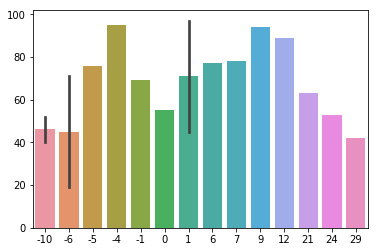

In [37]:
sns.barplot(rt[:100],range(100))

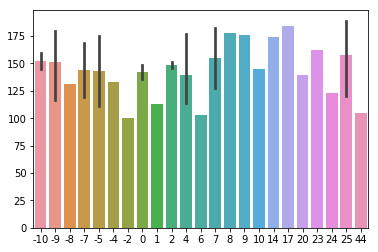

In [38]:
sns.barplot(rt[100:200],range(100,200))

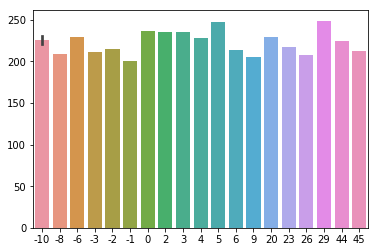

In [41]:
sns.barplot(rt[200:250],range(200,250))

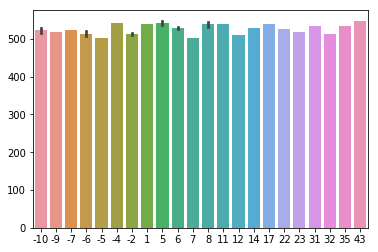

In [42]:
sns.barplot(rt[500:550],range(500,550))

In [16]:
accuracy=[]
rounds=[]
for i in range(50):
    w,l,round1=agent.test()
    t=w+l
    accuracy1=((w/t)*100)
    rounds.append(round1)
    accuracy.append(accuracy1)
    
    
print(accuracy)
print("Average rounds: " , sum(rounds)/50.0)
print("Minimum rounds: ", min(rounds))
print("Maximum rounds: ", max(rounds))

print("*****\(*o*)/*****")

Average rounds:  43.32
Minimum rounds:  10
Maximum rounds:  49


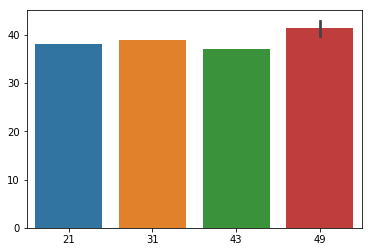

In [22]:
sns.barplot(rounds[:10],accuracy[:10])

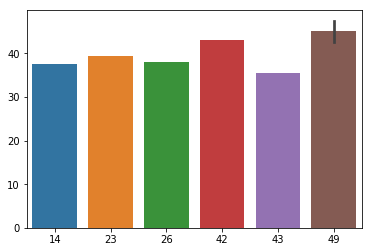

In [24]:
sns.barplot(rounds[10:30],accuracy[10:30])

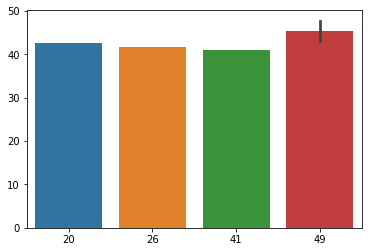

In [43]:
sns.barplot(rounds[30:40],accuracy[30:40])

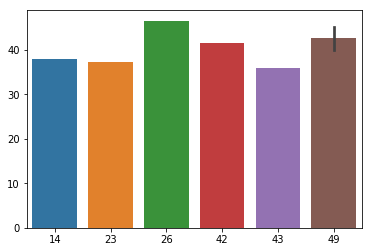

In [45]:
sns.barplot(rounds[10:30],accuracy[30:50])

# Plots observation 

I have plotted various graphs accuracy against number of rounds. I plotted these graphs to look for which particular round what my accuracy is. I wanted to check for what rounds what accuracies where. It can be observed how accuracy is with respect to rounds. x-axis is accuracy(win rate) and y axis is counts for the rounds. 49% of win rate is counted for 40th round. 

# Run experiments to find good parameters


## Show the experimental outputs to show the process of your selections 

I have attached the plots to my directory assignment4. 

- In this part, I have used bruteforce to find good parameters for my model. For each parameter I used a for loop to determine the best parameter with respect to win rate accuracy. 
- For finding best parameter value for alpha I'm setting other parameters as 0.1. I'm making them stable. So I'm only finding best parameter with respect to others being static. 
- I did the same thing for gamma and epsilon. 
- I have obtained the following results. 
- I had to disable print statement to obtain the result since printing makes the browser crash and train slow compared to not printing. 

In [46]:
alpha=[]
accuracy=[]
for i in tqdm(range(11)):
    agent=RLAgent()
    rt,q=agent.train(gamma=0.99,alpha=0.1*i,epsilon=0.1,maxiter=1000)
    alpha.append(round((0.1*i),1))
    w,l,j1=agent.test()
    t=w+l
    accuracy1=((w/t)*100)
    accuracy.append(accuracy1)
    

print("Alpha: ",alpha)
print("Accuracy: ",accuracy)


    

100%|██████████| 11/11 [00:28<00:00,  2.55s/it]


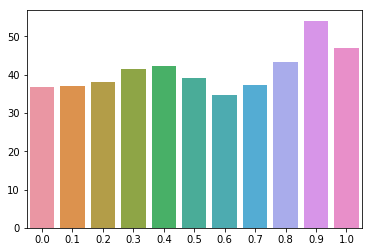

In [47]:
max_alpha=accuracy.index(max(accuracy))
sns.barplot(alpha[:],accuracy[:])

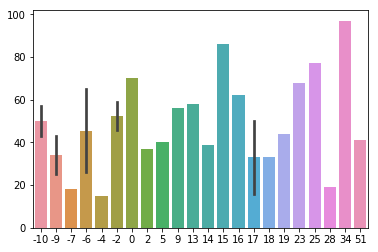

In [48]:
sns.barplot(rt[:100], range(100))


In [49]:
epsilon=[]
accuracy=[]
for i in tqdm(range(11)):
    agent=RLAgent()
    rt,q=agent.train(gamma=0.99,alpha=0.1,epsilon=(1.0-(0.1*i)),maxiter=1000)
    epsilon.append(round((0.1*i),1))
    w,l,j1=agent.test()
    t=w+l
    accuracy1=((w/t)*100)
    accuracy.append(accuracy1)

100%|██████████| 11/11 [00:19<00:00,  2.48s/it]


In [50]:
print("Epsilon: ",epsilon)
print("Accuracy: ",accuracy)
max_epsilon=accuracy.index(max(accuracy))



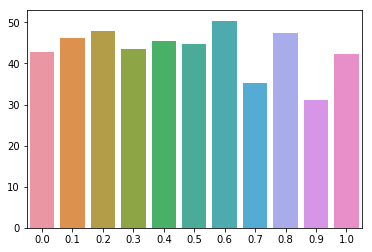

In [51]:
sns.barplot(epsilon[:],accuracy[:])

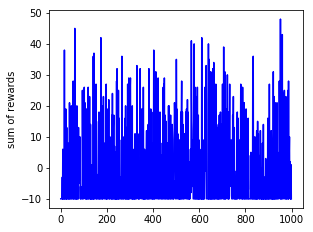

In [52]:
plot_train(agent, rt)

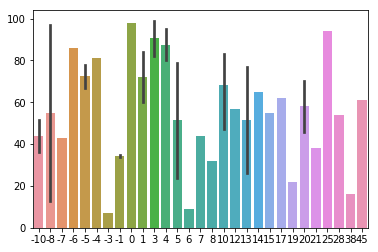

In [54]:
sns.barplot(rt[:100],range(100))

In [55]:
gamma=[]
accuracy=[]
for i in tqdm(range(11)):
    agent=RLAgent()
    rt,q=agent.train(gamma=0.9+(0.01*i),alpha=0.1,epsilon=0.1,maxiter=1000)
    gamma.append(round((0.9+(0.01*i)),2))
    w,l,j=agent.test()
    t=w+l
    accuracy1=((w/t)*100)
    accuracy.append(accuracy1)

100%|██████████| 11/11 [00:33<00:00,  3.02s/it]


In [56]:
print("Gamma: ",gamma)
print("Accuracy: ",accuracy)
max_gamma=accuracy.index(max(accuracy))

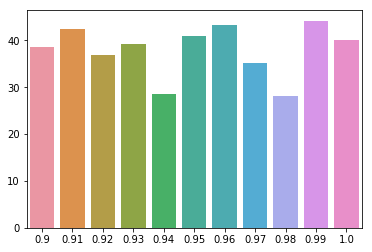

In [57]:
#plt.plot(gamma[:],accuracy[:])
#plt.xlabel("Gamma")
#plt.ylabel("Win Rate")
sns.barplot(gamma[:],accuracy[:])

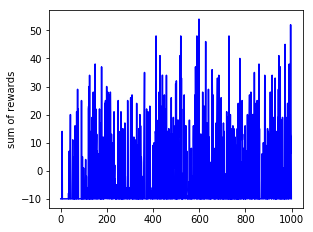

In [58]:
plot_train(agent, rt)

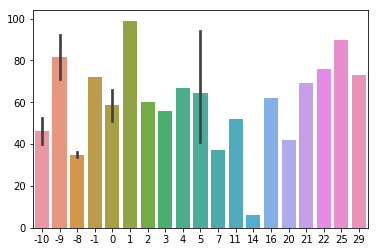

In [59]:
sns.barplot(rt[:100],range(100))

# Report the selected Parameters 

We can observe from the graph that what value is better for alpha, gamma and epsilon. These values are stored in max_alpha, max_gamma and max_epsilon. I've used these parameters to train my final model and test it using these parameters. <br> <br>

It can be observed from the graph that: 
- Win rate vs Alpha : In this graph we can observe that win rate is maximum for alpha=0.7. Good alpha values can be 0.1,0.4 and 0.7

- Win rate vs Epsilon : In this graph we can observe that win rate is maximum for epsilon=0.1. Good epsilon values can be 0.1 and 0.3

- Win rate vs Gamma: In this graph we can observe that win rate is maximum for gamma=0.94. Good gamma values can be 0.94,0.96 and 0.99. 


I chose the values that are maximum and stored them in max_alpha, max_epsilon and max_gamma variables. 

# Training with best parameters

In [60]:
agent=RLAgent()
rt,q=agent.train(gamma=max_gamma,alpha=max_alpha,epsilon=max_epsilon,maxiter=1000)



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:128: RuntimeWarning: overflow encountered in double_scalars
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in double_scalars
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:126: RuntimeWarning: overflow encountered in double_scalars
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:126: RuntimeWarning: invalid value encountered in double_scalars
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:157: RuntimeWarning: overflow encountered in double_scalars
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in double_scalars
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:156: RuntimeWarning: invalid value encountered in double_scalars
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:156: RuntimeWarning: overflow encountered in double_scalars


# Testing with best parameters

In [61]:
accuracy=[]
rounds=[]
for i in range(50):
    w,l,round1=agent.test()
    t=w+l
    accuracy1=((w/t)*100)
    rounds.append(round1)
    accuracy.append(accuracy1)
    
    
print(accuracy)
print("Average rounds: " , sum(rounds)/50.0)
print("Minimum rounds: ", min(rounds))
print("Maximum rounds: ", max(rounds))

print("*****\(*o*)/*****")

print("Average accuracy: " , sum(accuracy)/50.0)
print("Minimum accuracy: ", min(accuracy))
print("Maximum accuracy: ", max(accuracy))


Average rounds:  27.32
Minimum rounds:  6
Maximum rounds:  49


Text(0, 0.5, 'Accuracy')

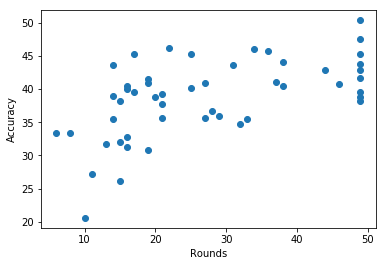

In [62]:
plt.scatter(rounds[:],accuracy[:])
plt.xlabel("Rounds")
plt.ylabel("Accuracy")

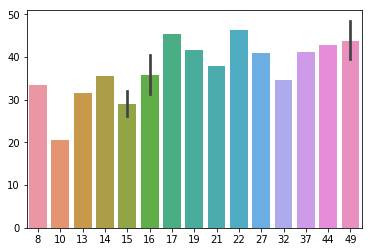

In [68]:
sns.barplot(rounds[:20],accuracy[:20])

## Visualize the results and explain outputs

# Experimental outputs that show the choice of parameters. How do you choose them

# Reading and analysis of learning results and plots


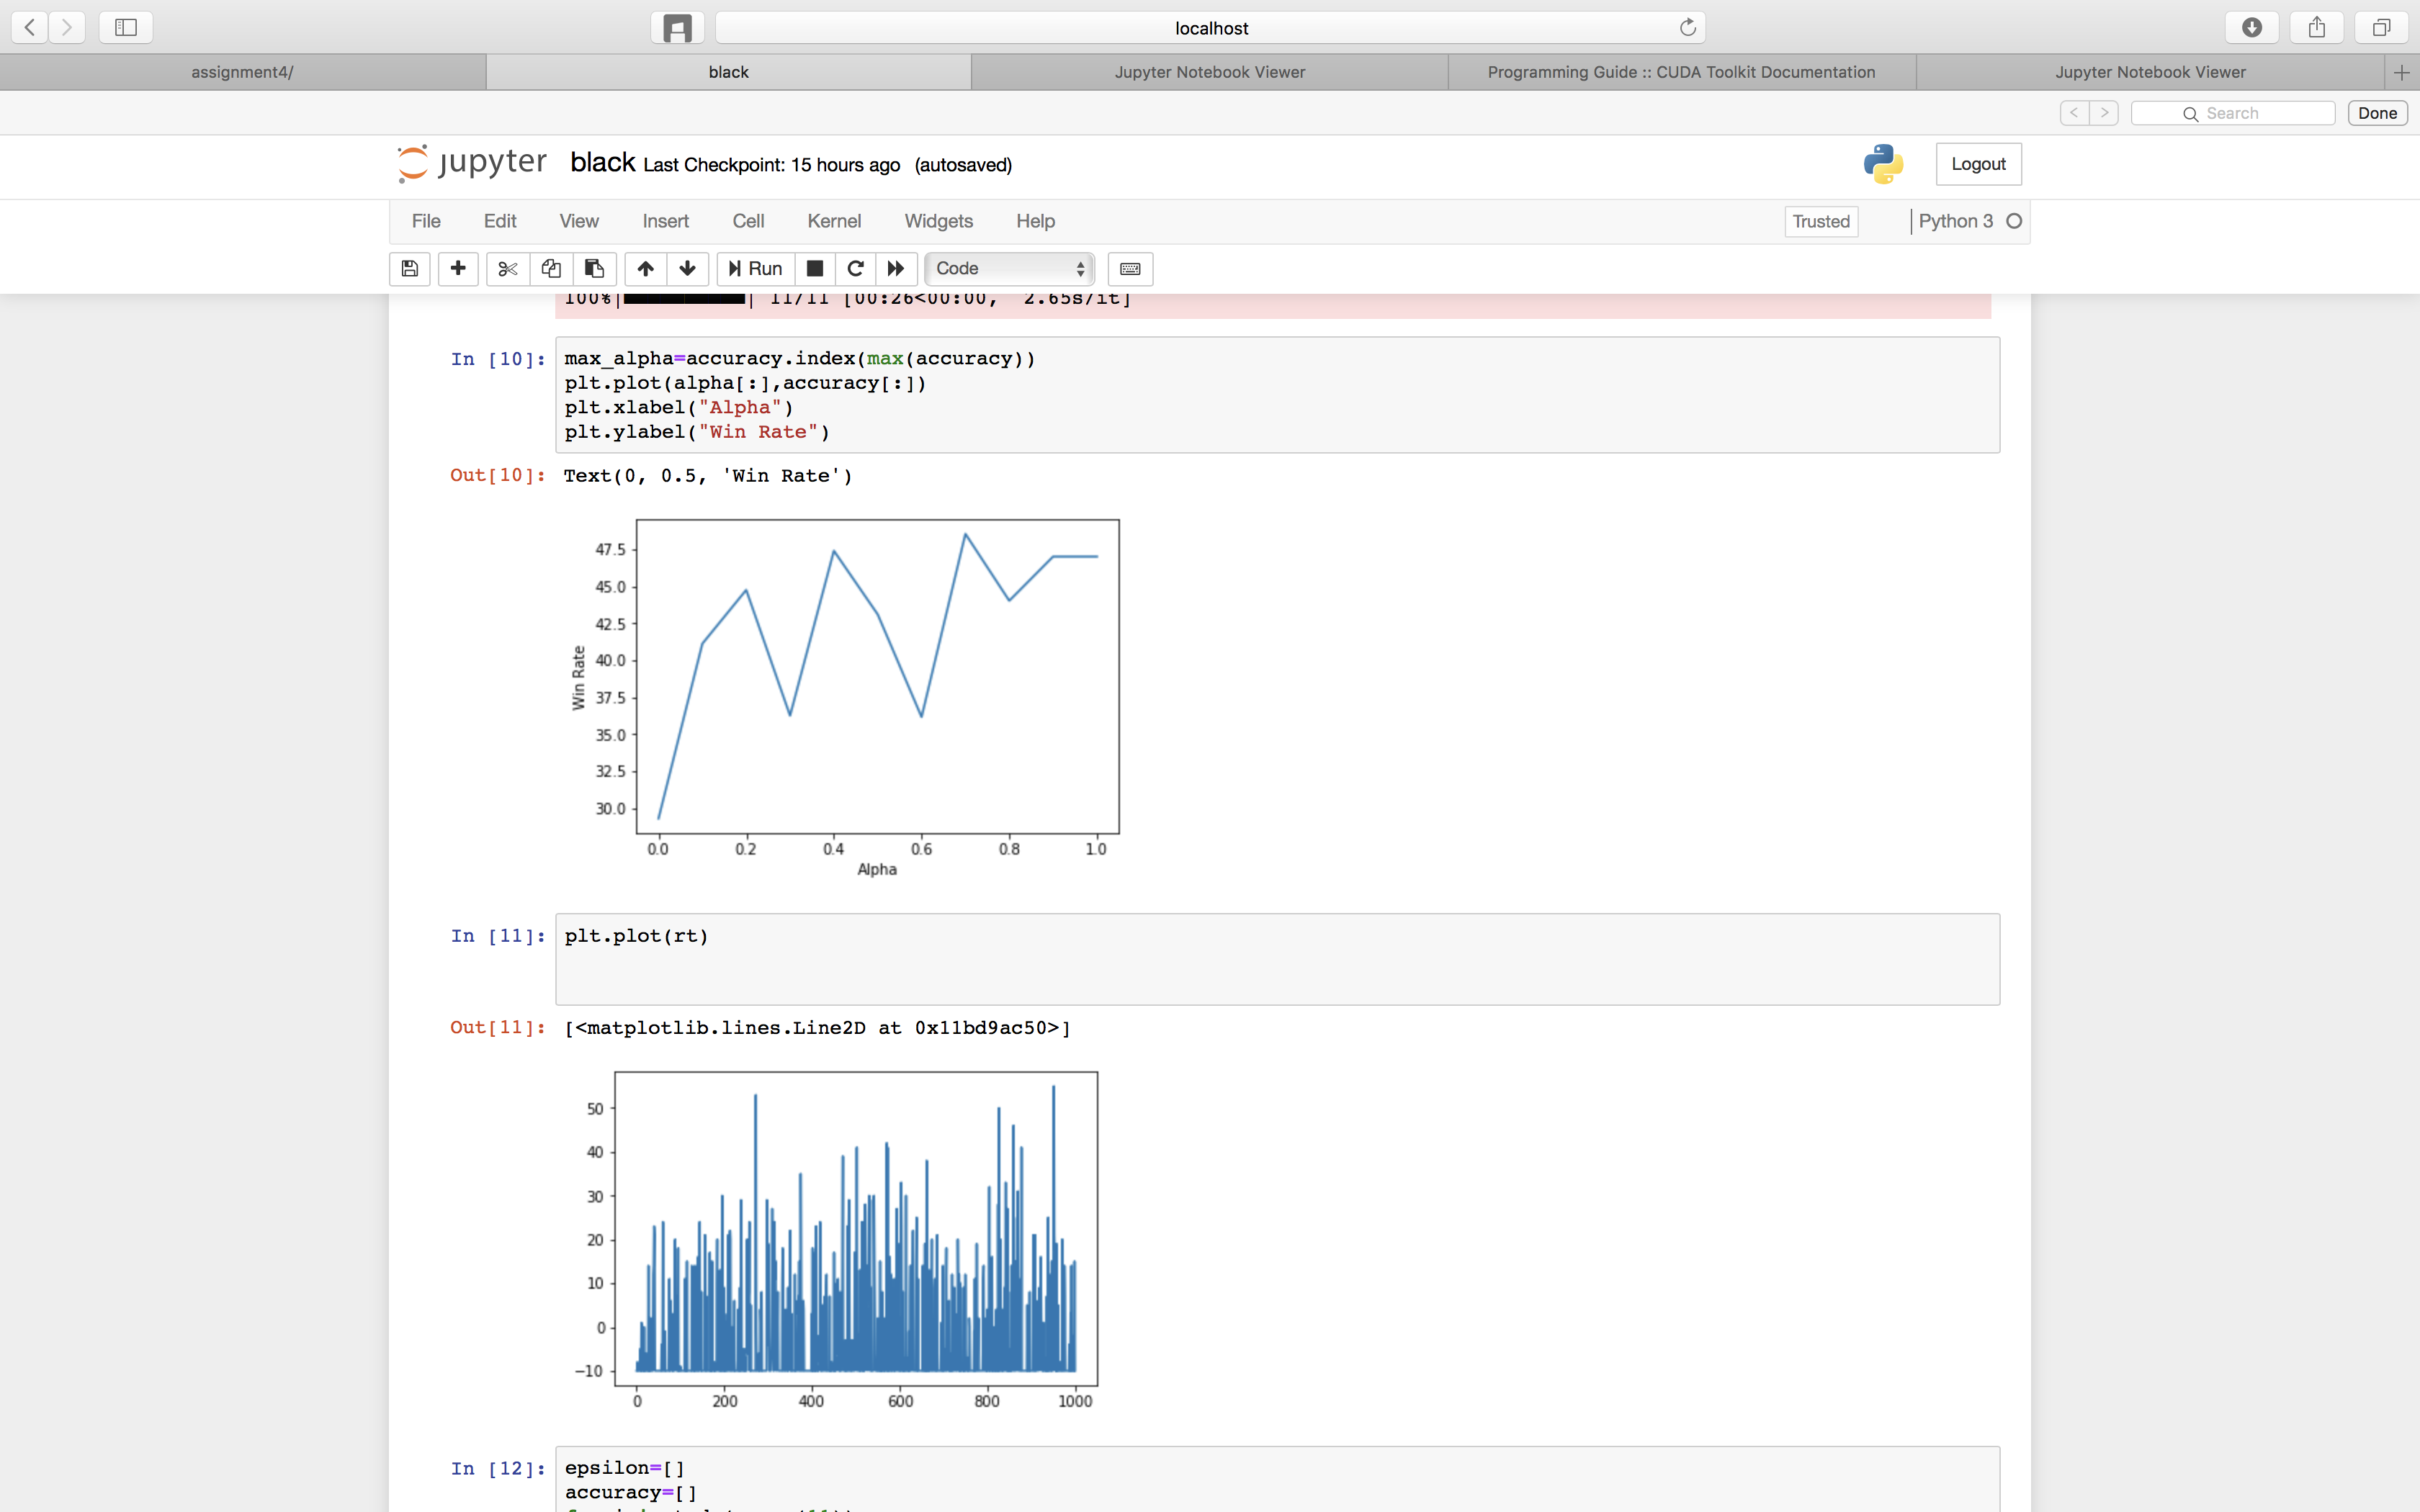

Win rate vs Alpha : In this graph we can observe that win rate is maximum for alpha=0.7. Good alpha values can be 0.1,0.4 and 0.7. This graph was obtained when I used brute force to find the best value for alpha when gamma and epsilon are set .99 and  zero respectively. I'm setting the range of alpha 0.0 to 1.0



The second graph shows the reward sum trace that is how total rewards fluctuates with respect to number of iterations. It can be observed that since there is good wining the reward obtained  reached 50 and minimum reward obtained was around -10.

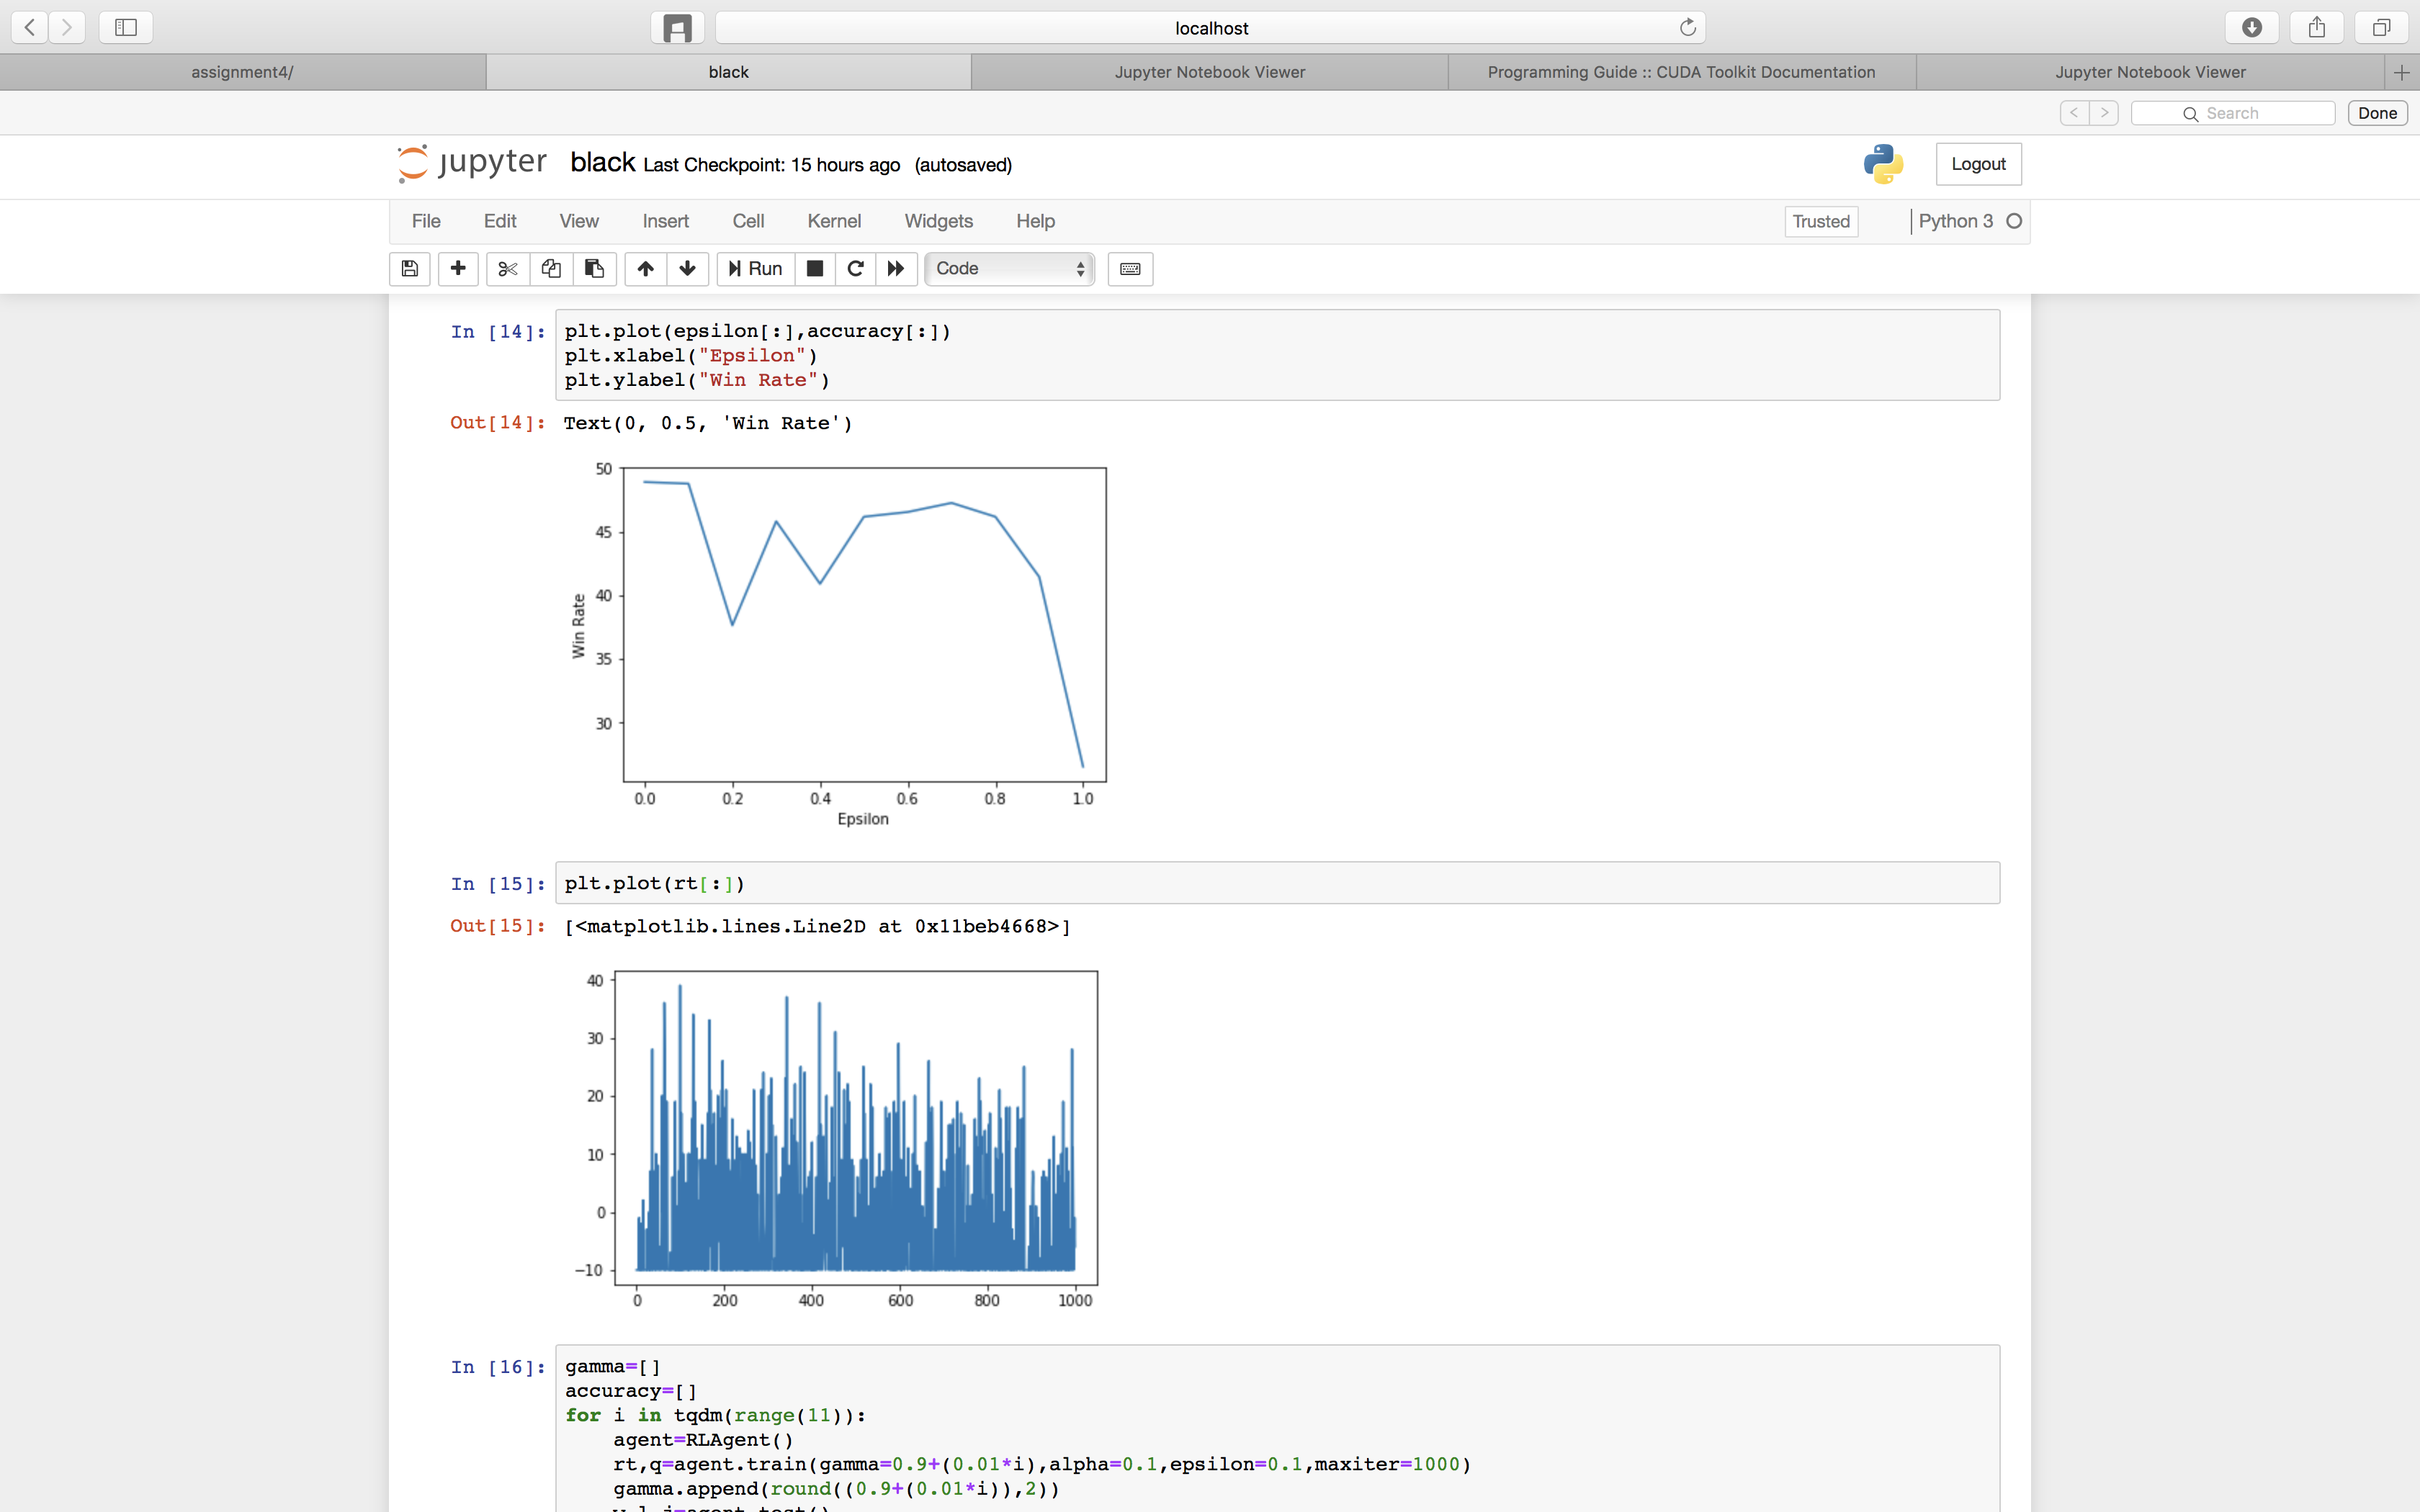

Win rate vs Epsilon : In this graph we can observe that win rate is maximum for epsilon=0.1. Good epsilon values can be 0.1 and 0.3. This graph was obtained when I used brute force to find the best value for epsilon when gamma and alpha are set .99 and  zero respectively. I'm setting the range of epsilon 0.0 to 1.0

The second graph shows the reward sum trace that is how total rewards fluctuates with respect to number of iterations. It can be observed that since there is good wining the reward obtained  reached 40 and minimum reward obtained was around -10. 

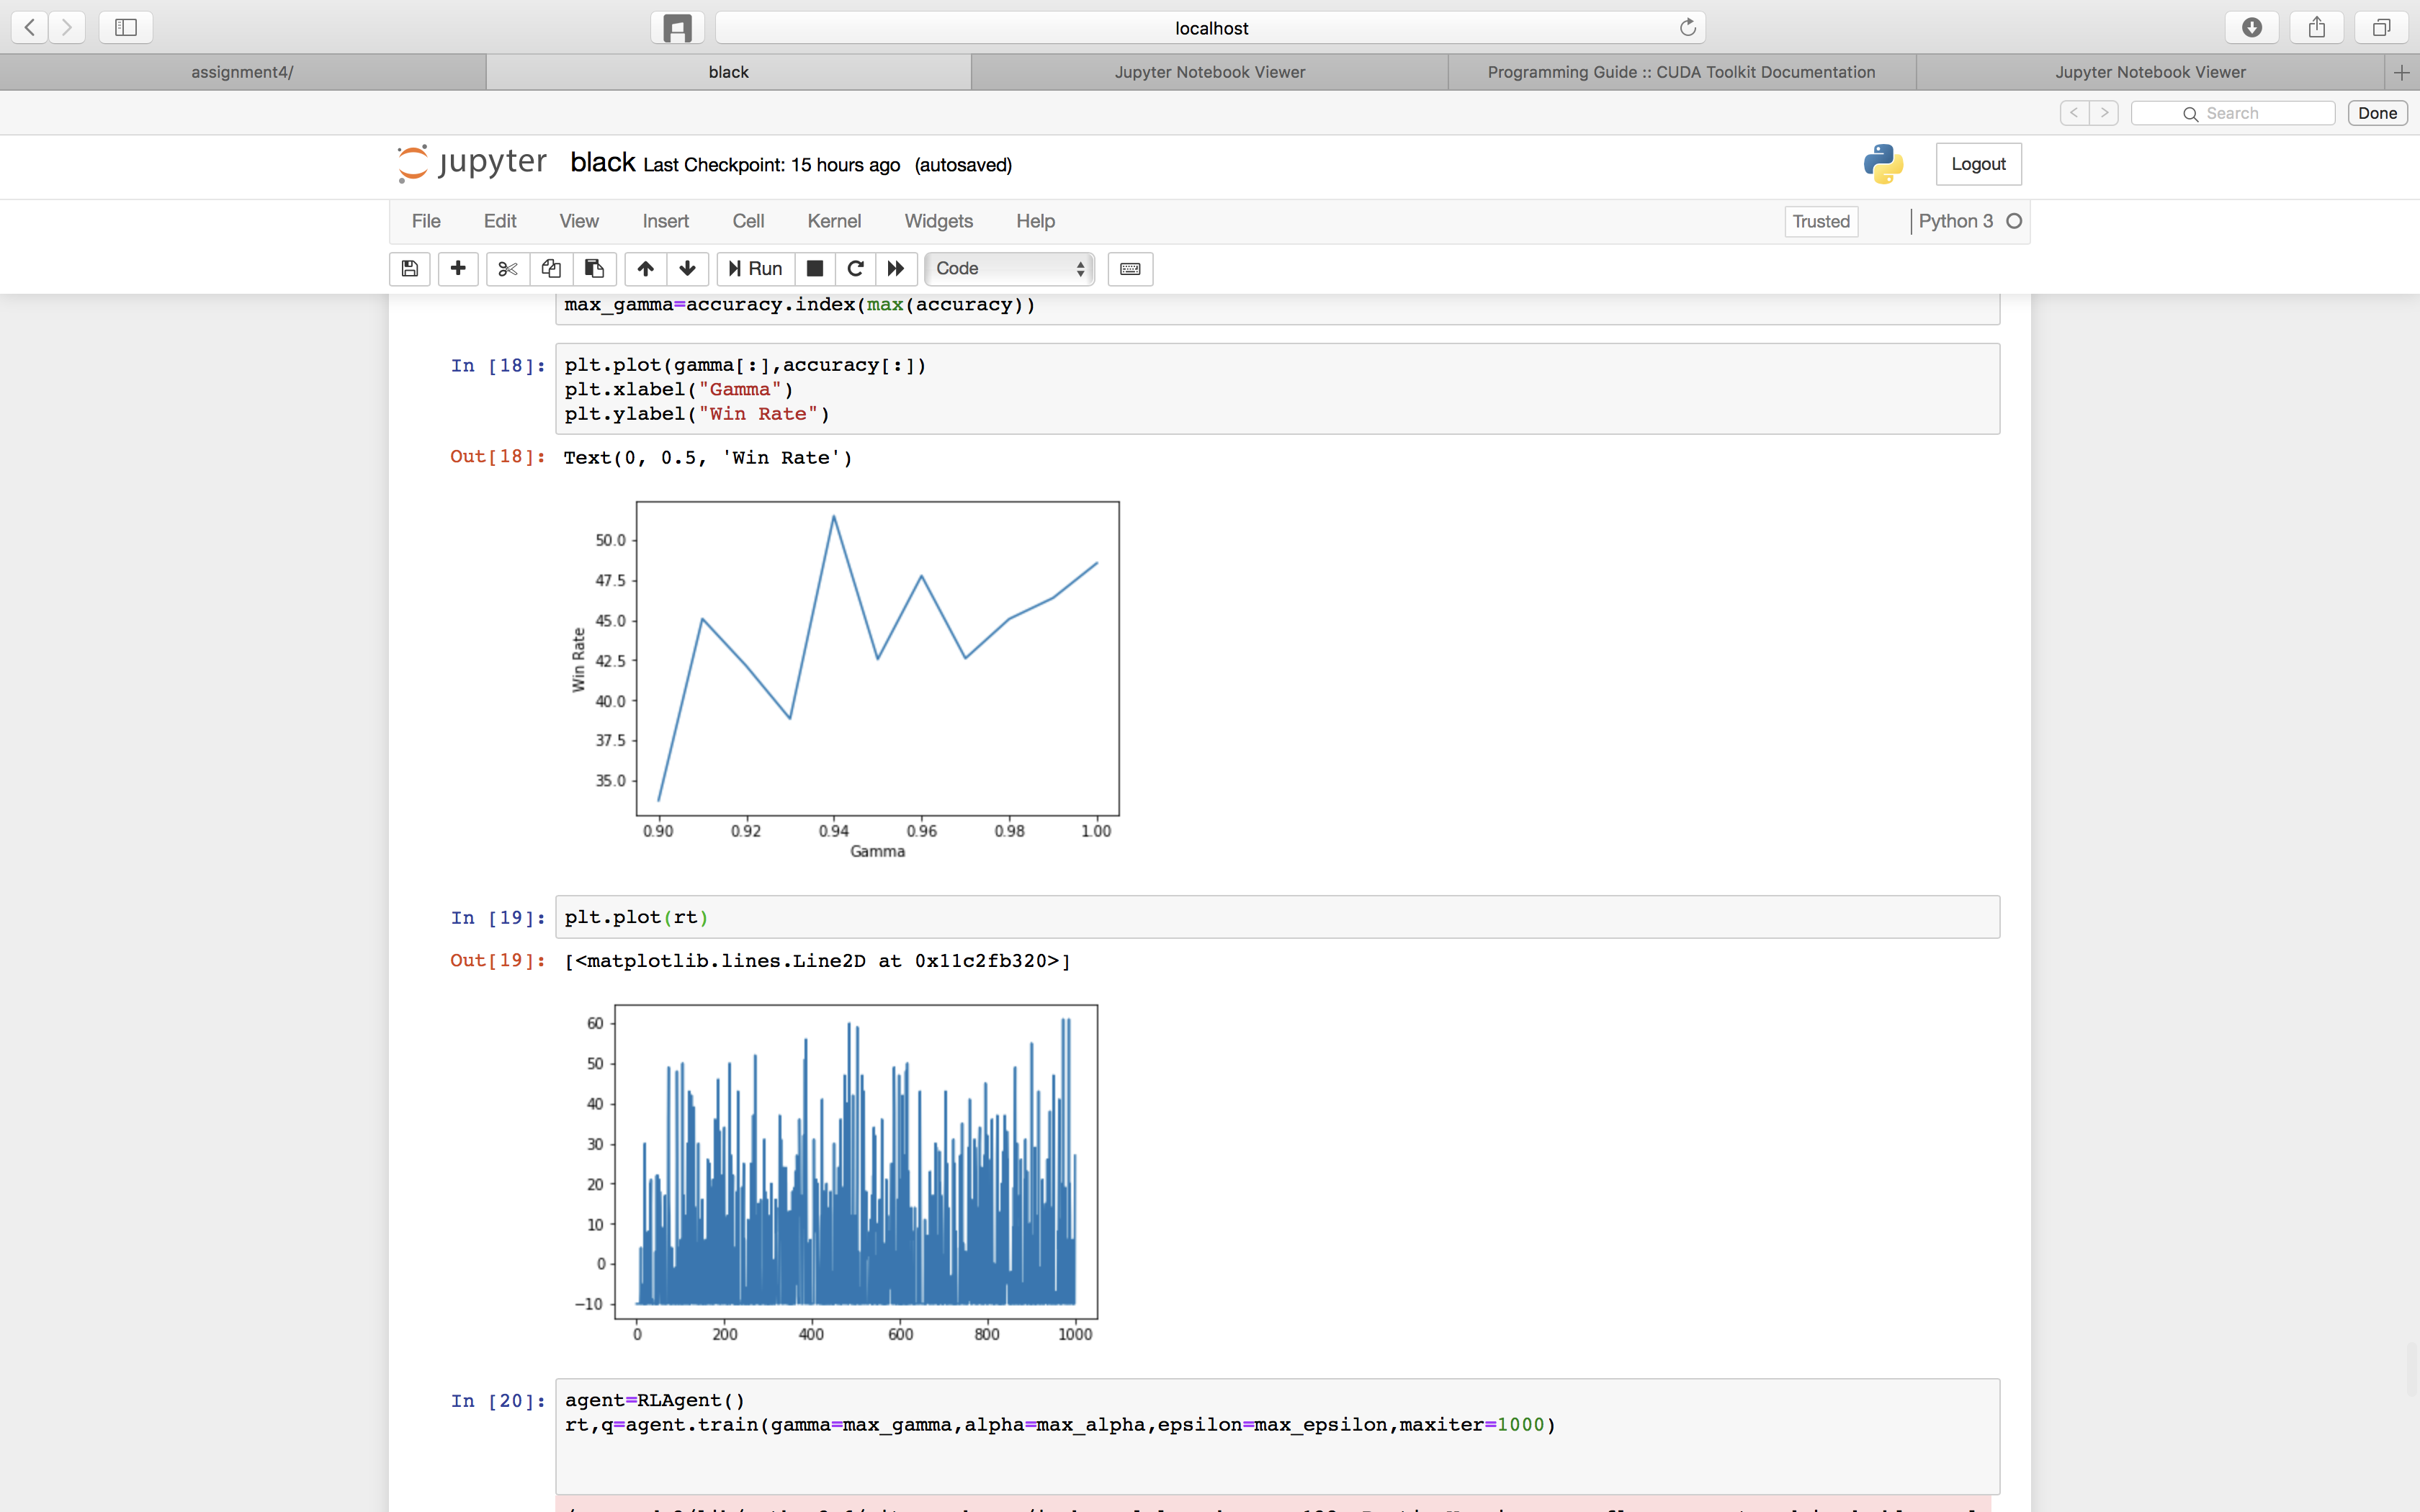


Win rate vs Gamma: In this graph we can observe that win rate is maximum for gamma=0.94. Good gamma values can be 0.94,0.96 and 0.99. This graph was obtained when I used brute force to find the best value for gamma when epsilon and alpha are set as zero. I'm setting the range of gamma to .9 to 1.0 since I was getting good results for this range of gamma values. 

The second graph shows the reward sum trace that is how total rewards fluctuates with respect to number of iterations. It can be observed that since there is good wining the reward obtained reached 60 and minimum reward obtained was around -10. 



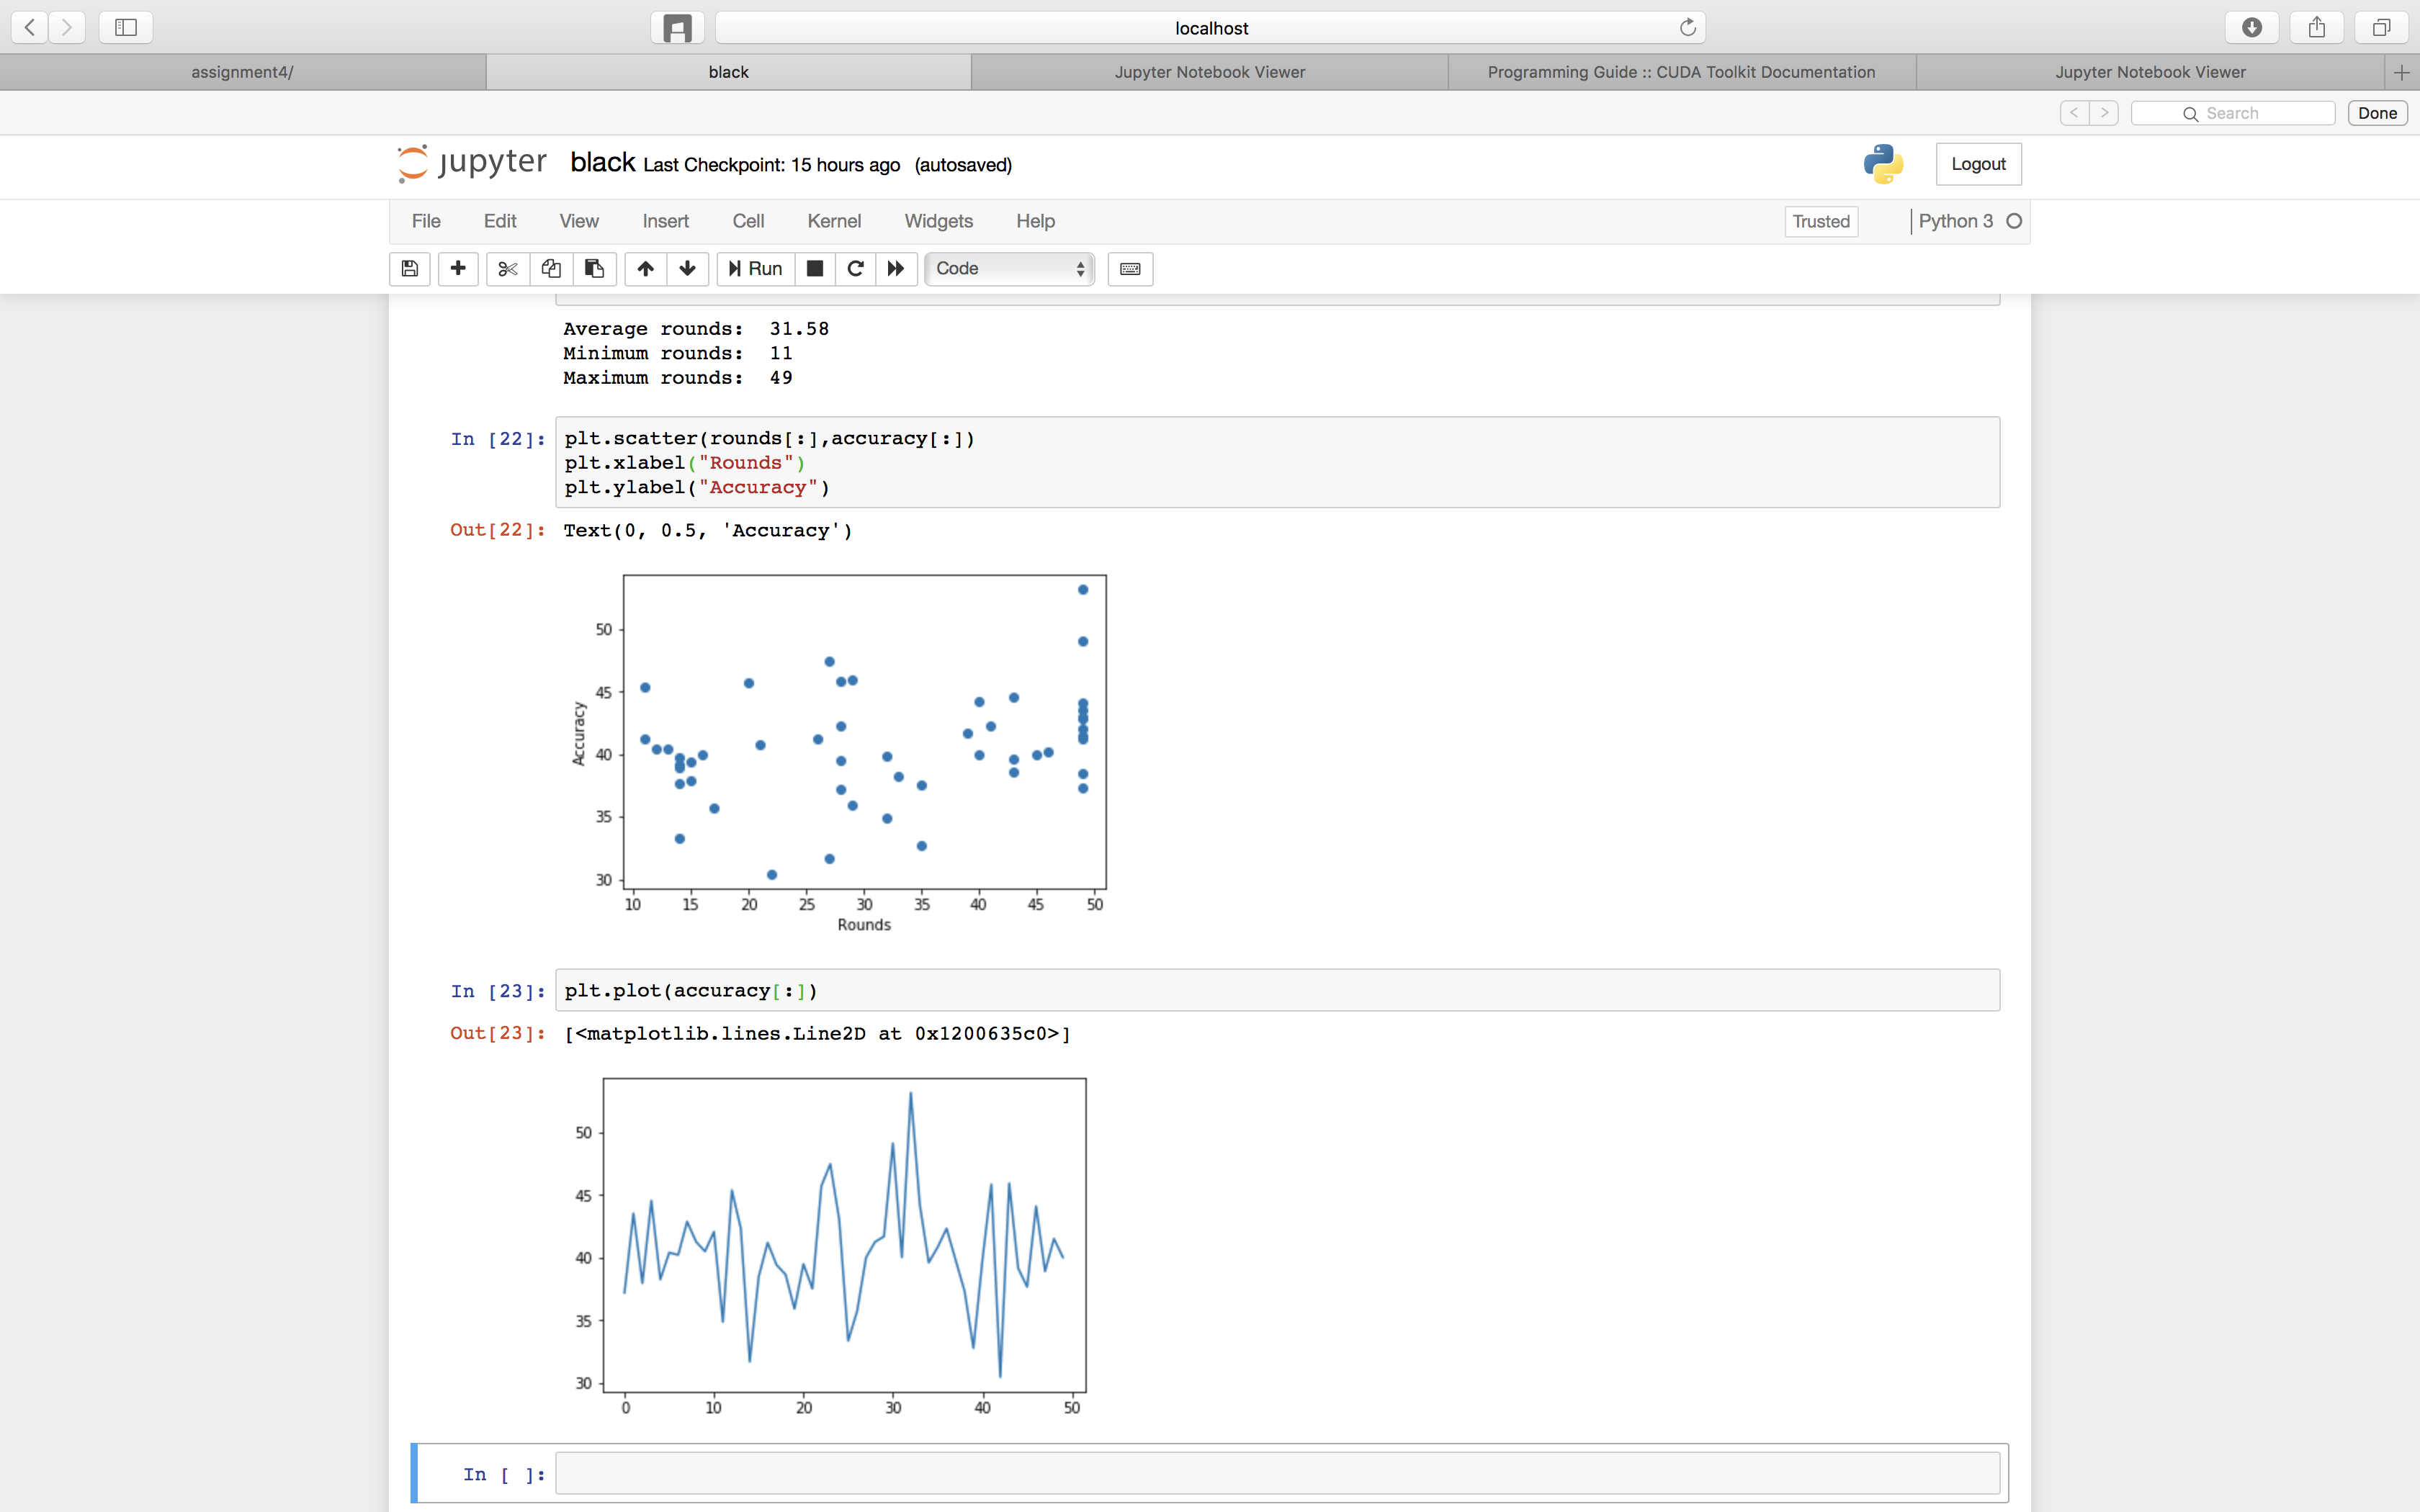

Win rate vs Rounds: In this graph we can observed that how accuracy(win rate) is varying with respect to number of rounds. It can be observed that accuracy is around 40 for maximum times. This implies the agent is able to win 40% of time. This is a good wining rate. This implies that my Gambler Agent is gambling (betting) at better rate than random bets. Since random bets can lead to lesser win rate sometimes. This graph was obtained after choosing the best parameters. 

In the second graph we can observe the win rate for my agent. I had problems achieving this win rate since I was betting randomly. But when I created a betting agent, my winning rate suddenly increased (as it can be observed from the graph). This is because now the Gambler Agent is trained to bet high when the reward was good for agent for states that was seen before in the Q1 table and bet low for when the agent was punished for the same state before by looking at the Q1 table. This graph was obtained after choosing the best parameters.

# Conclusion 

RL Agent cannot be judged based on win rate or number of rounds it survived, for one game only. Since the number of rounds and win rate for different game is different. We cannot judge it for one game, but if we try 2 or 3 games then we can observed a good judging criteria for the RL Agent. In this assignment, I have learned how to train a Reinforcement Learning agent. In this assignment, I have faced many issues with the keyError for Q table and dimension problems. This assignment made me read many research paper to attain good win rate and better average number of rounds. 

# Tournament Extra credit

I'll use DQN and train my model with better parameters. I'll train it for more iterations so that my agent is able to explore more states and when the same states are observed during the testing, my agent will perform better by betting high or low which will be decided by my Gambler Agent. 
